In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("/home/maddie/SmartIoT-2025/GANs models/")
from ad_utils import *

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda0
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Fold 1 - Using original normal data only
Processing data through feature extraction...
Processing 110 samples with multi-channel approach...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Training autoencoder...
Training Binary Classification SVM...

Fold 1 Results:
--------------------------------------------------
F1_Threshold       | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Accuracy_Threshold | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Binary_SVM         | Acc: 0.9143 | Prec: 1.0000 | Rec: 0.5714 | F1: 0.7273

========================= FOLD 2/5 =========================
Fold 2 - Train normal: 110
Fold 2 - Train faulty: 30
Fo

/home/maddie/SmartIoT-2025/GANs models/ad_utils.py:879: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(methods, rotation=45, ha='right')


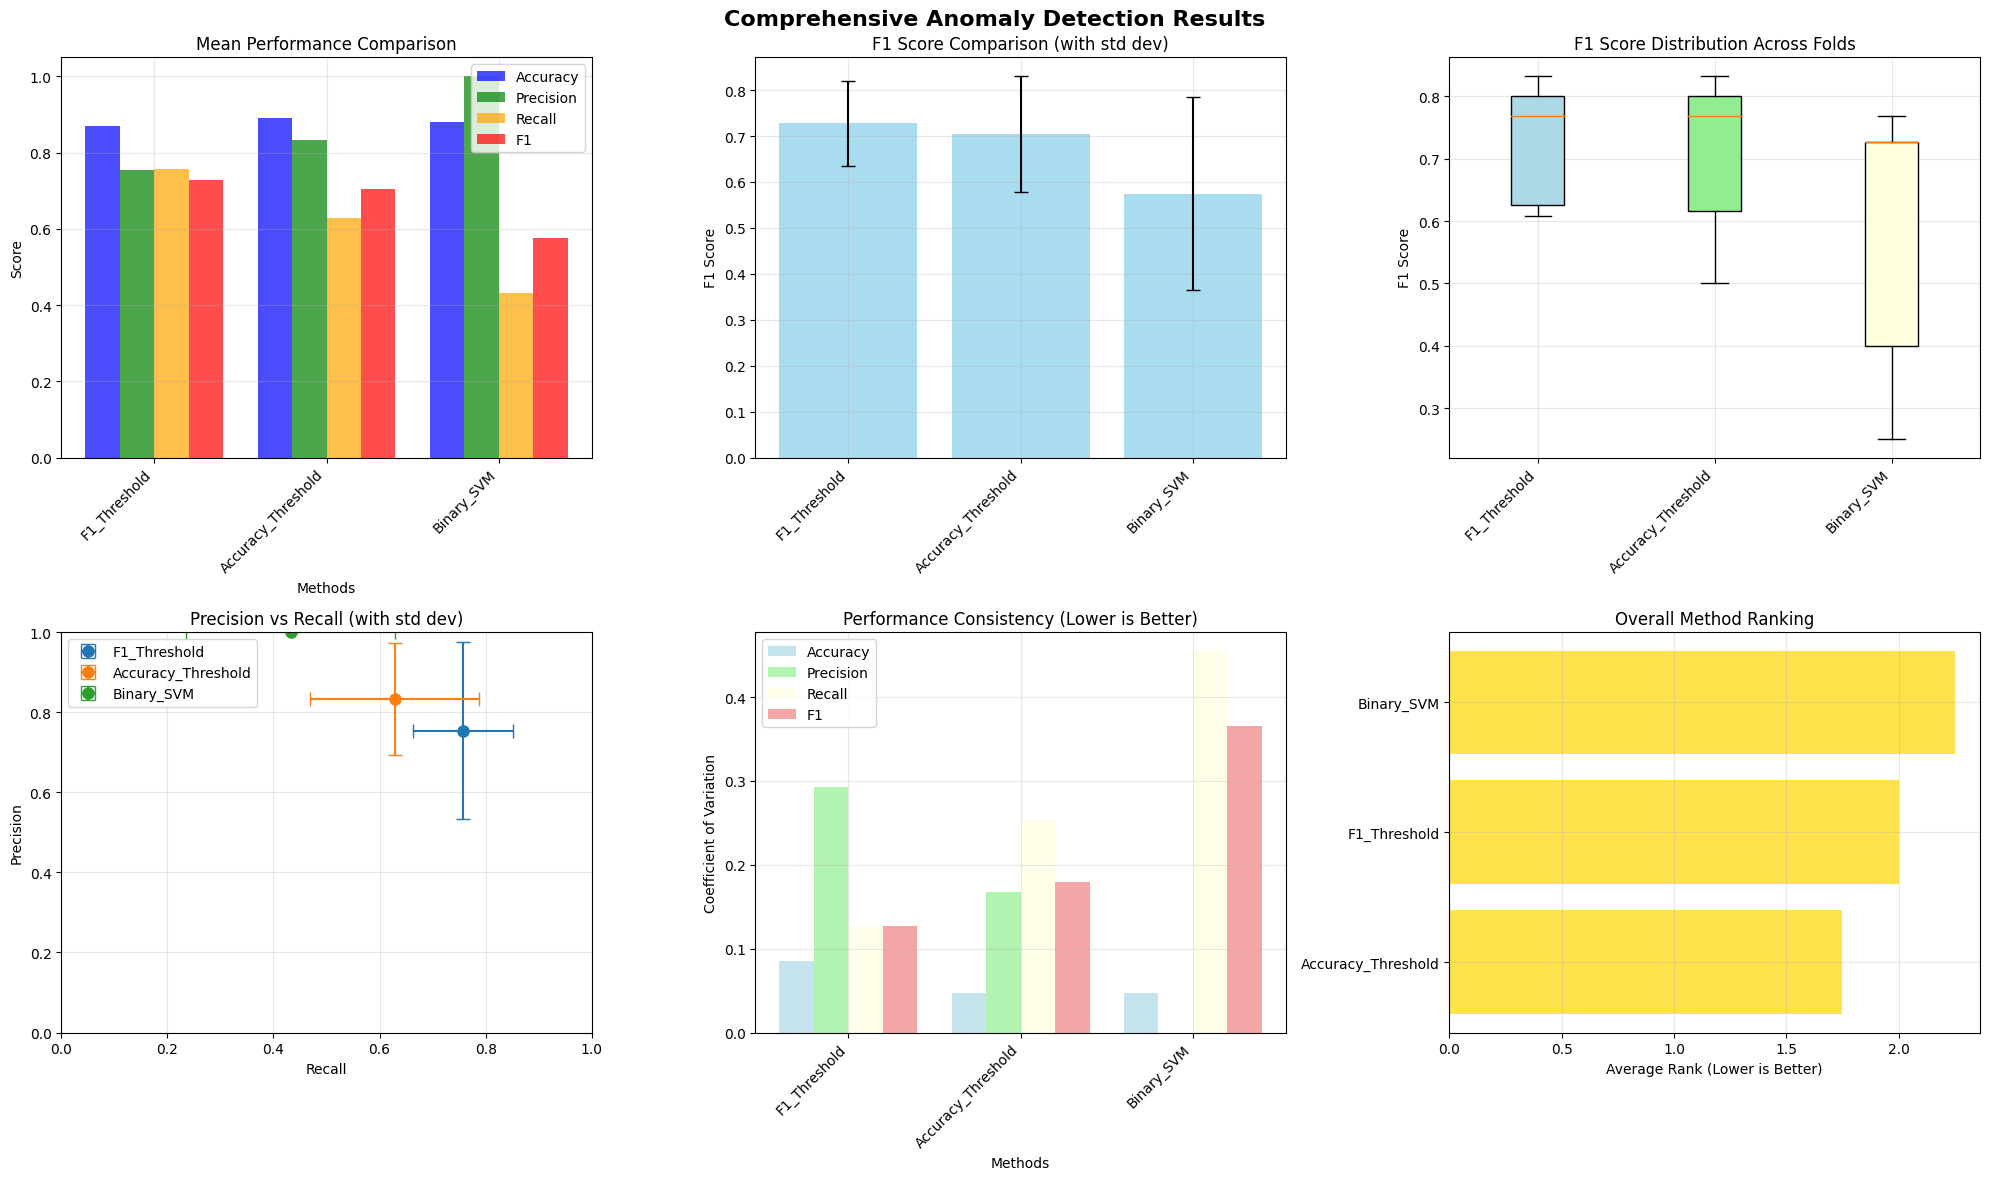


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.7273)
   • Best Accuracy: Accuracy_Threshold (0.8914)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : Balanced precision and recall, Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • Binary_SVM            : High Precision (fewer false alarms), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8685714285714287,
    'std': 0.07362342129557212,
    'values': [0.9142857142857143,
     0.8285714285714286,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.7544444444444445,
    'std': 0.2204484766656316,
    'values': [0.75, 0.5555555555555556, 1.0, 1.0, 0.4666666666666667]},
   'recall': {'mean': 0.7571428571428571,
    'std': 0.09489521611133157,
    'values': [0.8571428571428571,
     0.7142857142857143,
     0.7142857142857143,
     0.625,
     0.875]},
   'f1': {'mean': 0.7272519509476031,
    'std': 0.09254060402413204,
    'values': [0.7999999999999999,
     0.6250000000000001,
     0.8333333333333333,
     0.7692307692307693,
     0.608695652173913]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8914285714285715,
    'std': 0.04199125273342589,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.828571428571428

In [2]:
run_comprehensive_cross_validation_experiment(normal_data=X_test_normal, faulty_data=X_test_faulty, device=device, batch_size=32)